In [6]:
import gdown

file_id = "1eZj-usKeuH_f3wtZxvpOG2zxA-JLuzQj"
url = f"https://drive.google.com/uc?id={file_id}"
output = "tesla-stock-price.csv"

gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1eZj-usKeuH_f3wtZxvpOG2zxA-JLuzQj
To: /content/tesla-stock-price.csv
100%|██████████| 55.4k/55.4k [00:00<00:00, 28.0MB/s]


'tesla-stock-price.csv'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.1316 - val_loss: 0.0108
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0195 - val_loss: 0.0121
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0148 - val_loss: 0.0116
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0113 - val_loss: 0.0096
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0

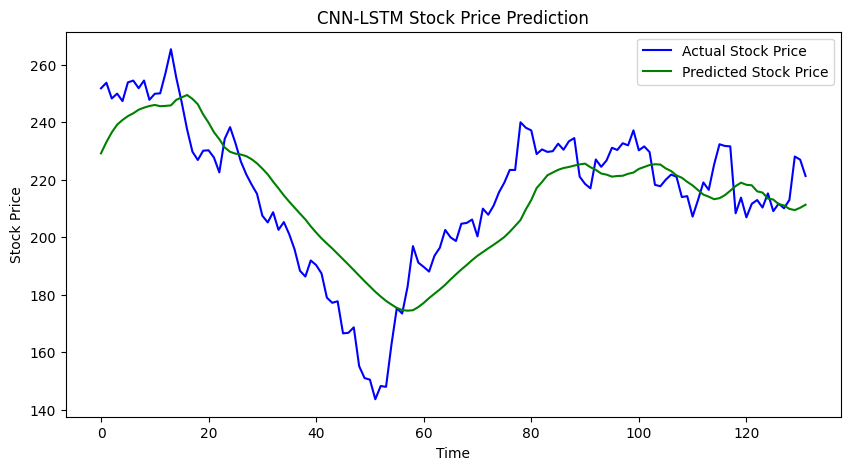

Root Mean Squared Error (RMSE): 14.340548099330817


In [8]:
# Install dependencies (if not installed)
!pip install tensorflow pandas numpy scikit-learn matplotlib

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load dataset
d_data = pd.read_csv('/content/tesla-stock-price.csv')

# Ensure correct column name (check if 'Close' or 'Adj Close')
stock_prices = d_data['close'].values.reshape(-1, 1)

# Scale stock prices for LSTM
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_prices)

# Function to create sequences for CNN-LSTM
def seq_creation(data, seq_length):
    a, b = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length), 0]  # Extract sequences
        a.append(seq)
        b.append(data[i + seq_length, 0])  # Predict next stock price
    return np.array(a), np.array(b)

# Define sequence length
seq_length = 100
X, Y = seq_creation(scaled_data, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape for CNN-LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-LSTM Model
model = Sequential()

# CNN Feature Extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Prevent overfitting

# Keep the time-series structure
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to get actual stock prices
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot actual vs predicted stock prices
plt.figure(figsize=(10,5))
plt.plot(Y_test, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='green', label='Predicted Stock Price')
plt.title('CNN-LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate RMSE for accuracy check
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')
